In [1]:
import torch
from torch import nn
import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor
from torch.nn.utils import skip_init
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt
import numpy as np
from sys import maxsize
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from collections import OrderedDict

## Part 1


### Data Loading

In [51]:
TRAIN_SIZE = 5000
TEST_SIZE = 1000

gen = torch.Generator()
gen.manual_seed(2022)

trainset = torchvision.datasets.CIFAR10(root = './data', train = True, download = True, 
                                        transform = transforms.ToTensor())

sample_train_idx = torch.randint(len(trainset), size=(TRAIN_SIZE,), generator = gen)



testset = torchvision.datasets.CIFAR10(root = './data', train = False,
                                       download = True, transform = transforms.ToTensor())
sample_test_idx = torch.randint(len(testset), size=(TEST_SIZE,), generator = gen)


Files already downloaded and verified
Files already downloaded and verified


### Training an SVM Classifier 

In [52]:
MAX_INTENSITY = 255

train_x = trainset.data/MAX_INTENSITY
train_y = trainset.targets

test_x = testset.data/MAX_INTENSITY
test_y = testset.targets

train_x = train_x.reshape(train_x.shape[0], -1)
train_x = train_x[sample_train_idx,:]
train_y = np.array(train_y)[sample_train_idx]

test_x = test_x.reshape(test_x.shape[0], -1)
test_x = test_x[sample_test_idx,:]
test_y = np.array(test_y)[sample_test_idx]

#### Hyperparameter Tuning

In [88]:
param_grid1 = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.001],'kernel': ['rbf']}
param_grid2 = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.001],'kernel': ['linear']}

grid1 = GridSearchCV(SVC(),param_grid1, refit=True, verbose=2, n_jobs = -1)
grid2 = GridSearchCV(SVC(),param_grid2, refit=True, verbose=2, n_jobs = -1)

grid1.fit(train_x, train_y)
print("best parameters for grid1: ", grid1.best_params_)

grid2.fit(train_x, train_y)
print("best parameters for grid2: ", grid2.best_params_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


KeyboardInterrupt: ignored

#### Training the Models

In [89]:
# The follwing are the parameters found to be best:
params1 = {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
params2 = {'C': 0.1, 'gamma': 1, 'kernel': 'linear'}

rbf_model = SVC(C = params1["C"], kernel = "rbf", gamma = params1["gamma"])
linear_model = SVC(C = params2["C"], kernel = "linear", gamma = params2["gamma"])

rbf_model.fit(train_x, train_y)
linear_model.fit(train_x, train_y)

test_pred_rbf = rbf_model.predict(test_x)
test_pred_linear = linear_model.predict(test_x)

print(f"""accuracy score for linear model is: {accuracy_score(test_y, test_pred_linear)} \n 
        accuracy score for rbf model is: {accuracy_score(test_y, test_pred_rbf)}""")

KeyboardInterrupt: ignored

##Neural Networks Preliminaries

In [38]:
labels = ['train_accuracy', 'test_accuracy', 'train_loss', 'test_loss']

def train_loop(dataloader, model, loss_fn, optimizer, device, print_progress = False):
    model.train()
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if print_progress&(batch % 100 == 0):
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test_loop(dataloader, model, loss_fn, device, return_results = False):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        model.eval()
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    
    test_loss /= num_batches
    correct /= size
    if return_results:
      return test_loss, correct

def train_and_return_results(trainloader, testloader, model, loss_fn, optimizer, epochs, device):
  train_accuracy_vals, train_loss_vals, test_accuracy_vals, test_loss_vals = [], [], [], []
  for t in range(epochs):
    train_loop(trainloader, model, loss_fn, optimizer, device)
    train_loss, train_accuracy = test_loop(trainloader, model, loss_fn, device, True)
    test_loss, test_accuracy = test_loop(testloader, model, loss_fn, device, True)
    train_loss_vals.append(train_loss)
    train_accuracy_vals.append(train_accuracy)
    test_loss_vals.append(test_loss)
    test_accuracy_vals.append(test_accuracy)
  return train_accuracy_vals, train_loss_vals, test_accuracy_vals, test_loss_vals

def plot_results(models_results):
  figure = plt.figure(figsize=(18, 6))
  ax1 = figure.add_subplot(1,2,1)
  ax2 = figure.add_subplot(1,2,2)
  ax1 = figure.get_axes()[0]
  ax2 = figure.get_axes()[1]
  x_axis = [i for i in range(epochs)]
  for results, labels in models_results:
    ax1.plot(x_axis, results[0], label=labels[0])
    ax1.plot(x_axis, results[2], label=labels[2])
    ax2.plot(x_axis, results[1], label=labels[1])
    ax2.plot(x_axis, results[3], label=labels[3])
  ax1.legend()
  ax2.legend()
  figure.show()

def train_and_plot_results(trainloader, testloader, model, loss_fn, optimizer, epochs, device):
  results = train_and_return_results(trainloader, testloader, model, loss_fn, optimizer, epochs, device)
  print("accuracy: ", results[2][-1], " loss: ", results[3][-1])
  plot_results([(results, labels)])

####Initialization and Hyperparameter Tuning

In [39]:
batch_size = 64

trainsubset = torch.utils.data.Subset(trainset, sample_train_idx)
testsubset = torch.utils.data.Subset(testset, sample_test_idx)
trainloader = torch.utils.data.DataLoader(trainsubset, batch_size = batch_size,
                                          num_workers=2, shuffle = True)
testloader = torch.utils.data.DataLoader(testsubset, batch_size = batch_size,
                                          num_workers=2, shuffle = True)

loss_fn = nn.CrossEntropyLoss()

In [40]:
learning_rate_vals = [1e-1, 1e-2, 1e-3, 1e-4]
init_std_vals = [1e-3, 1e-1, 1]
momentum_param_vals = [0.9, 0.95, 0.99] 

best_configuration = {'learning_rate':None, 'init_std': None, 'momentum_param': None}

def init_weights_normal(model, init_std):
  for m in model.modules():
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
      torch.nn.init.normal_(m.weight, mean=0.0, std=init_std)
      if m.bias is not None:
        torch.nn.init.normal_(m.bias, mean=0.0, std=init_std)

def hyper_parameters_grid_search(model, loss_func):
  best_loss = maxsize
  for learning_rate in learning_rate_vals:
    for init_std in init_std_vals:
      for momentum_param in momentum_param_vals:
        init_weights_normal(model, init_std)
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum_param)
        for t in range(epochs):
          train_loop(trainloader, model, loss_func, optimizer, device)
        loss, accuracy = test_loop(testloader, model, loss_func, device, True)
        print("learning rate: ", learning_rate, "init_std: ", init_std , "momentum_param: ", momentum_param, "loss: ", loss)
        if loss<best_loss:
          best_loss = loss
          best_configuration["learning_rate"] = learning_rate
          best_configuration["momentum_param"] = momentum_param
          best_configuration["init_std"] = init_std

## Part 2
### Baseline

In [41]:
class FFNeuralNetwork(nn.Module):
    def __init__(self):
        super(FFNeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        input_layer = nn.Linear(3072, 256)
        hidden_layer = nn.Linear(256, 10)
        self.linear_relu_stack = nn.Sequential(
            input_layer,
            nn.ReLU(),
            hidden_layer,
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [42]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

model = FFNeuralNetwork()

if torch.cuda.device_count() > 1:
  print("Using", torch.cuda.device_count(), "GPUs")
  model = nn.DataParallel(model)

model.to(device)
print(model)

Using cuda device
FFNeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=3072, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=10, bias=True)
  )
)


#### Plotting training procces with best configuration

accuracy:  0.404  loss:  1.6935221254825592


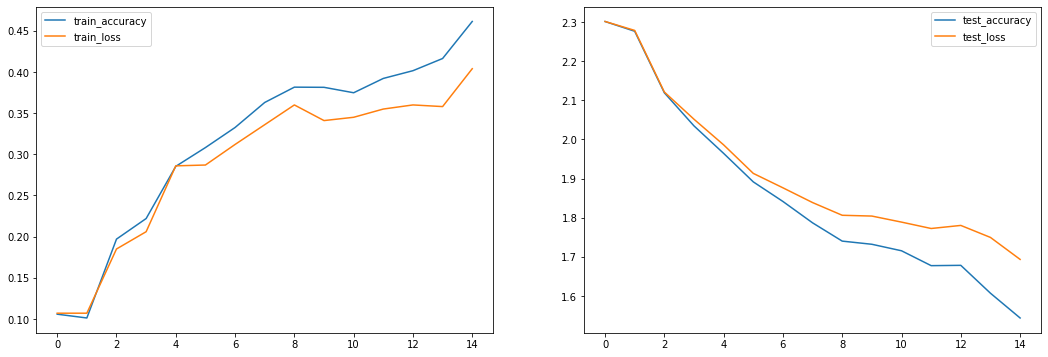

In [44]:
epochs = 10 # for sanity check only
hyper_parameters_grid_search(model, loss_fn)
init_weights_normal(model, best_configuration["init_std"])
optimizer = torch.optim.SGD(model.parameters(), lr=best_configuration["learning_rate"], momentum=best_configuration["momentum_param"])
train_and_plot_results(trainloader, testloader, model, loss_fn, optimizer, epochs, device)

#### Optimization

accuracy:  0.359  loss:  1.742522455751896


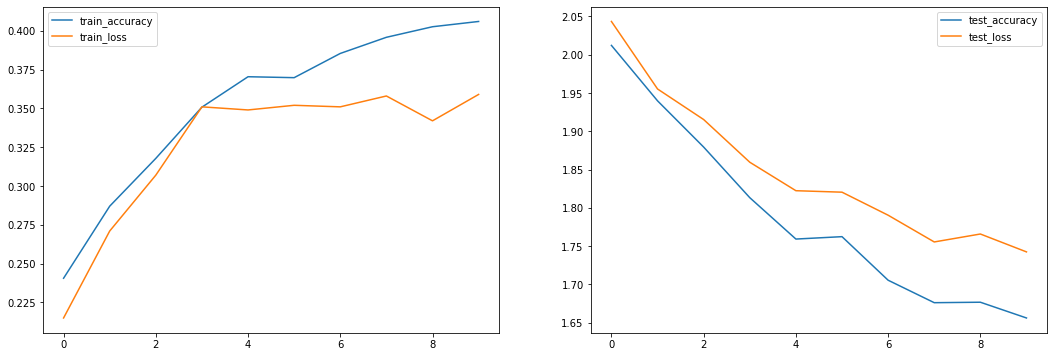

In [45]:
init_weights_normal(model, best_configuration["init_std"])
optimizer = torch.optim.Adam(model.parameters(), betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
train_and_plot_results(trainloader, testloader, model, loss_fn, optimizer, epochs, device)

#### Initialization

accuracy:  0.378  loss:  1.7254997789859772


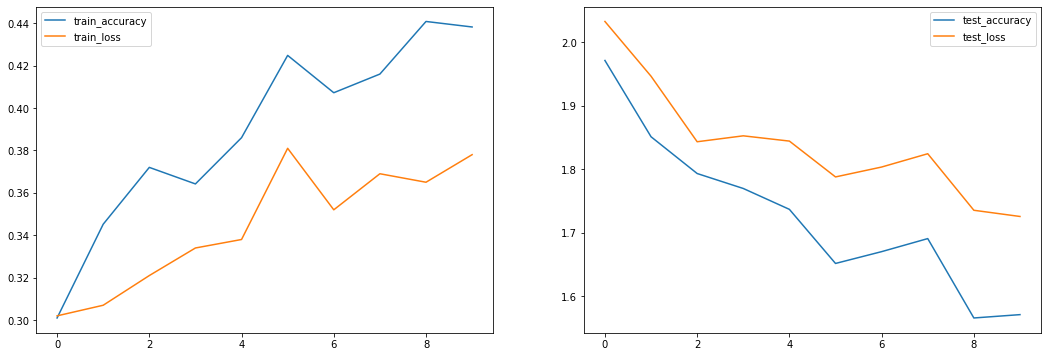

In [46]:
torch.nn.init.xavier_normal_(model.linear_relu_stack[0].weight)
torch.nn.init.xavier_normal_(model.linear_relu_stack[2].weight)
optimizer = torch.optim.SGD(model.parameters(), lr=best_configuration["learning_rate"], momentum=best_configuration["momentum_param"])
train_and_plot_results(trainloader, testloader, model, loss_fn, optimizer, epochs, device)

#### Weight Decay

accuracy:  0.353  loss:  1.7903836220502853


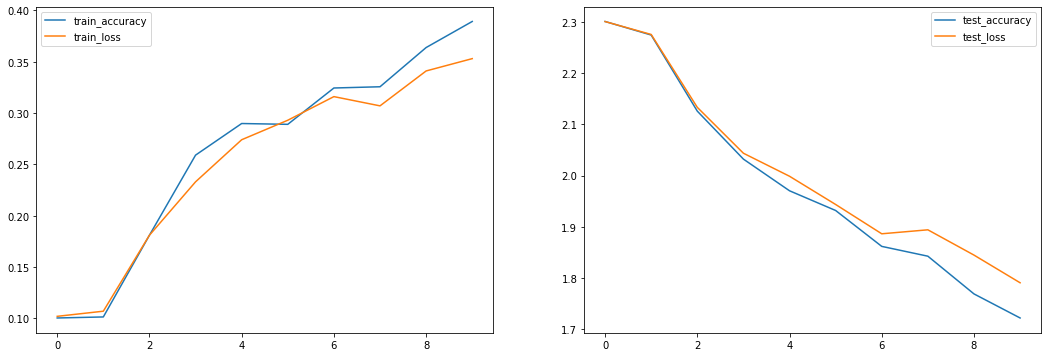

In [47]:
init_weights_normal(model, best_configuration["init_std"])
optimizer = torch.optim.SGD(model.parameters(), lr=best_configuration["learning_rate"], momentum=best_configuration["momentum_param"], weight_decay=1e-4)
train_and_plot_results(trainloader, testloader, model, loss_fn, optimizer, epochs, device)

#### Dropout

In [48]:
class FFNeuralNetworkDropout(nn.Module):
    def __init__(self):
        super(FFNeuralNetworkDropout, self).__init__()
        self.flatten = nn.Flatten()
        input_layer = nn.Linear(3072, 256)
        hidden_layer = nn.Linear(256, 10)
        self.linear_relu_stack = nn.Sequential(
            input_layer,
            nn.Dropout(0.25),
            nn.ReLU(),
            hidden_layer
            )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

accuracy:  0.34  loss:  1.822206698358059


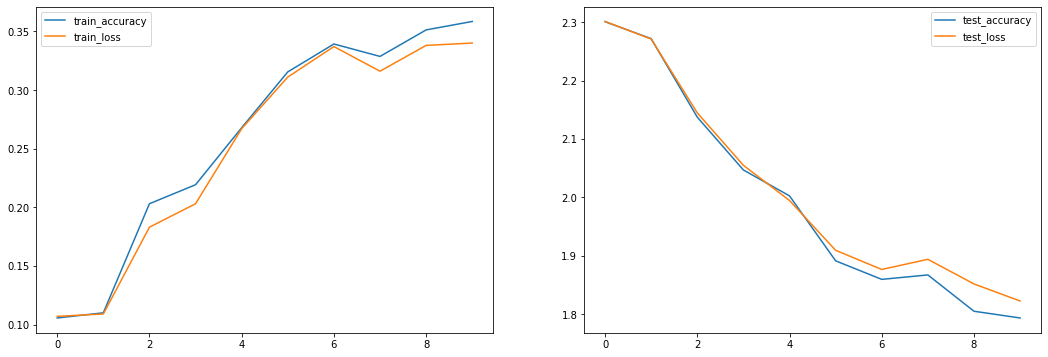

In [49]:
model = FFNeuralNetworkDropout().to(device)
init_weights_normal(model, best_configuration["init_std"])
optimizer = torch.optim.SGD(model.parameters(), lr=best_configuration["learning_rate"], momentum=best_configuration["momentum_param"])
train_and_plot_results(trainloader, testloader, model, loss_fn, optimizer, epochs, device)

#### PCA Whitening

accuracy:  0.121  loss:  2.434787929058075


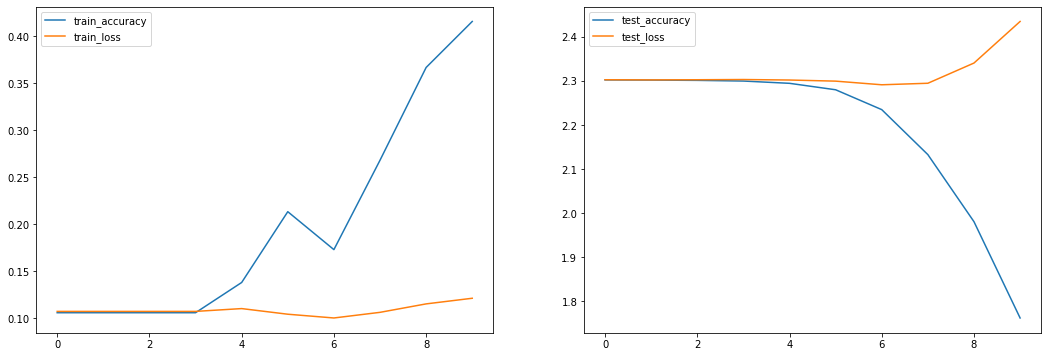

In [53]:
class FFNeuralNetworkPCA(nn.Module):
    def __init__(self):
        super(FFNeuralNetworkPCA, self).__init__()
        self.flatten = nn.Flatten()
        input_layer = nn.Linear(300, 256)
        hidden_layer = nn.Linear(256, 10)
        self.linear_relu_stack = nn.Sequential(
            input_layer,
            nn.ReLU(),
            hidden_layer,
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

pca = PCA(n_components=300, whiten=True, random_state=10)
train_x_pca = pca.fit_transform(train_x)
test_x_pca = pca.fit_transform(test_x)
tensor_trainx = torch.Tensor(train_x_pca)
tensor_trainy = torch.Tensor(train_y)
tensor_trainy = tensor_trainy.type(torch.LongTensor)
tensor_testx = torch.Tensor(test_x_pca)
tensor_testy = torch.Tensor(test_y)
tensor_testy = tensor_testy.type(torch.LongTensor)

trainset_pca = torch.utils.data.TensorDataset(tensor_trainx, tensor_trainy)
testset_pca = torch.utils.data.TensorDataset(tensor_testx, tensor_testy)

trainloader_pca = torch.utils.data.DataLoader(trainset_pca, batch_size = batch_size,
                                          num_workers=2, shuffle = True)
testloader_pca = torch.utils.data.DataLoader(testset_pca, batch_size = batch_size,
                                          num_workers=2, shuffle = True)

model = FFNeuralNetworkPCA().to(device)

init_weights_normal(model, best_configuration["init_std"])
optimizer = torch.optim.SGD(model.parameters(), lr=best_configuration["learning_rate"], momentum=best_configuration["momentum_param"])
train_and_plot_results(trainloader_pca, testloader_pca, model, loss_fn, optimizer, epochs, device)

#### Network Width

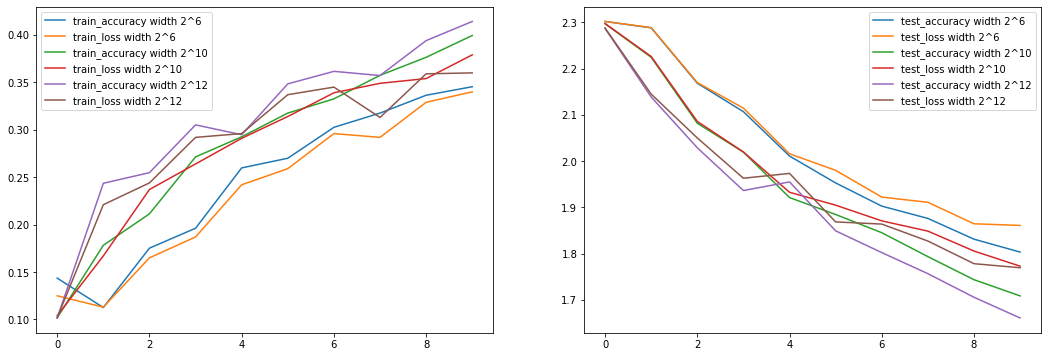

In [54]:
def NNClassGeneratorByWidth(width):
  class FFNeuralNetwork(nn.Module):
      def __init__(self):
          super(FFNeuralNetwork, self).__init__()
          self.flatten = nn.Flatten()
          input_layer = nn.Linear(3072, width)
          hidden_layer = nn.Linear(width, 10)
          self.linear_relu_stack = nn.Sequential(
              input_layer,
              nn.ReLU(),
              hidden_layer,
          )

      def forward(self, x):
          x = self.flatten(x)
          logits = self.linear_relu_stack(x)
          return logits
  return FFNeuralNetwork

width_vals = [6, 10, 12]
models_results = []
for width in width_vals:
  NNClass = NNClassGeneratorByWidth(2**width)
  model = NNClass().to(device)
  init_weights_normal(model, best_configuration["init_std"])
  optimizer = torch.optim.SGD(model.parameters(), lr=best_configuration["learning_rate"], momentum=best_configuration["momentum_param"])
  label_addition = f' width 2^{width}'
  curr_labels = [lbl + label_addition for lbl in labels]
  models_results.append((train_and_return_results(trainloader, testloader, model, loss_fn, optimizer, epochs, device), curr_labels))

plot_results(models_results)
  

#### Network Depth

In [55]:
def NNClassGeneratorByDepth(depth):
  class FFNeuralNetwork(nn.Module):
      def __init__(self):
          super(FFNeuralNetwork, self).__init__()
          self.flatten = nn.Flatten()
          sequence = OrderedDict()
          sequence['lin1'] = nn.Linear(3072, 64)
          for i in range(depth-1):
            sequence[f'rel{i+1}'] = nn.ReLU()
            sequence[f'lin{i+2}'] = nn.Linear(64, 64)
          sequence[f'rel{depth}'] = nn.ReLU()
          sequence[f'rel{depth + 1}'] = nn.Linear(64, 10)
          self.linear_relu_stack = nn.Sequential(sequence)

      def forward(self, x):
          x = self.flatten(x)
          logits = self.linear_relu_stack(x)
          return logits
  return FFNeuralNetwork

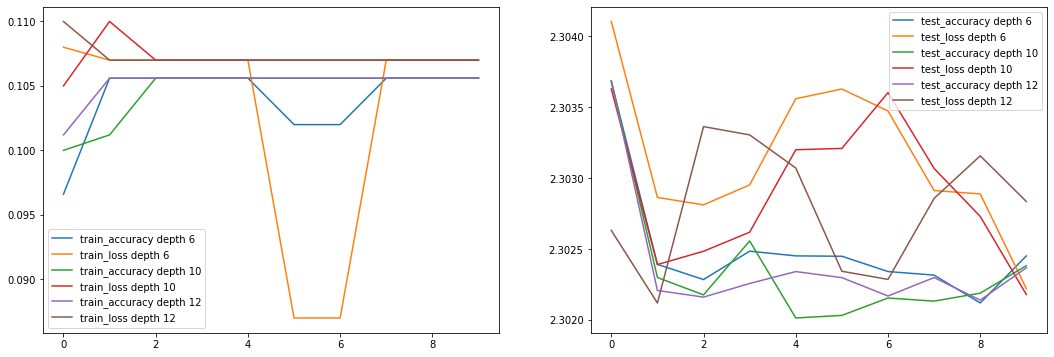

In [56]:
depth_vals = [6, 10, 12]
models_results = []
for depth in depth_vals:
  NNClass = NNClassGeneratorByDepth(depth)
  model = NNClass().to(device)
  for i in range(len(model.linear_relu_stack)):
    if i%2 == 0:
      torch.nn.init.normal_(model.linear_relu_stack[i].weight, mean=0.0, std=best_configuration['init_std'])
  optimizer = torch.optim.SGD(model.parameters(), lr=best_configuration["learning_rate"], momentum=best_configuration["momentum_param"])
  label_addition = f' depth {depth}'
  curr_labels = [lbl + label_addition for lbl in labels]
  models_results.append((train_and_return_results(trainloader, testloader, model, loss_fn, optimizer, epochs, device), curr_labels))

plot_results(models_results)

## Part 3


In [66]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.loss = nn.CrossEntropyLoss()
        self.classifier = nn.Sequential(
            nn.Conv2d(3, 64, 3),
            # nn.Dropout(0.15), # uncomment this line to enable dropout
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(64, 16, 3),
            # nn.Dropout(0.3), # uncomment this line to enable dropout
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2, ceil_mode=True),
            nn.Flatten(),
            nn.Linear(784, 10)
        )
    
    def forward(self, x):
        return self.classifier(x)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

conv_net = ConvNet().to(device)

Using cuda device


### Baseline

In [58]:
# after an initial search with the values above, we narrowed it down to the these options
learning_rate_vals = [0.01, 0.005]
init_std_vals = [0.1]
momentum_param_vals = [0.9, 0.95]
epochs = 5 # sanity check only
hyper_parameters_grid_search(model=conv_net, loss_func=conv_net.loss)
print("best configuration:", best_configuration)

learning rate:  0.01 init_std:  0.1 momentum_param:  0.9 loss:  1.7275211662054062
learning rate:  0.01 init_std:  0.1 momentum_param:  0.95 loss:  1.742563247680664
learning rate:  0.005 init_std:  0.1 momentum_param:  0.9 loss:  1.7356949001550674
learning rate:  0.005 init_std:  0.1 momentum_param:  0.95 loss:  1.7563692778348923
best configuration: {'learning_rate': 0.01, 'init_std': 0.1, 'momentum_param': 0.9}


accuracy:  0.405  loss:  1.6699400544166565


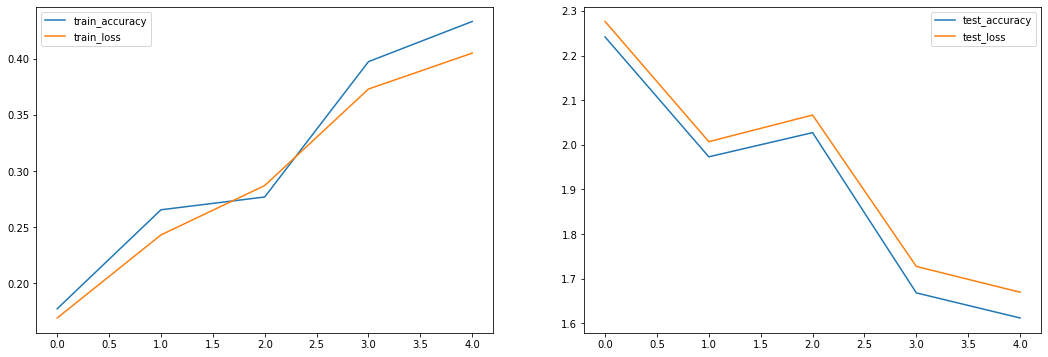

In [59]:
# plot results of best configuration
init_weights_normal(conv_net, best_configuration["init_std"])
optimizer = torch.optim.SGD(conv_net.parameters(), lr=best_configuration["learning_rate"], momentum=best_configuration["momentum_param"])
train_and_plot_results(trainloader, testloader, conv_net, conv_net.loss, optimizer, epochs, device)

###Optimization

accuracy:  0.426  loss:  1.5632151514291763


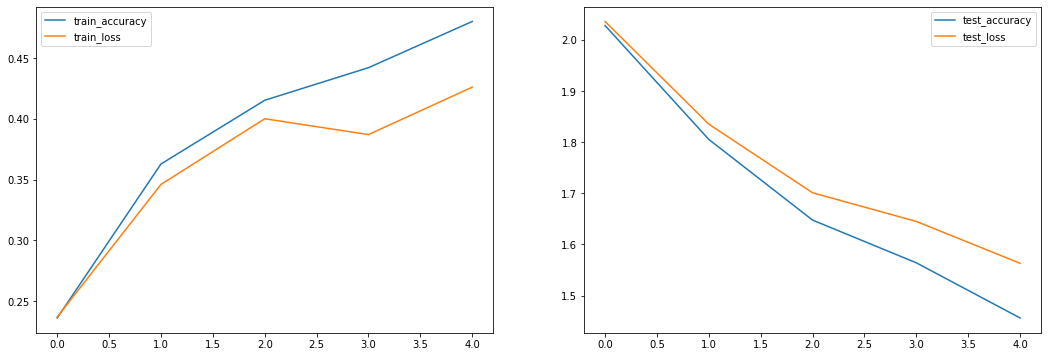

In [60]:
init_weights_normal(conv_net, best_configuration["init_std"])
optimizer = torch.optim.Adam(conv_net.parameters()) # note we are using default lr of 0.001
train_and_plot_results(trainloader, testloader, conv_net, conv_net.loss, optimizer, epochs, device)

###Initialization

accuracy:  0.414  loss:  1.6756484284996986


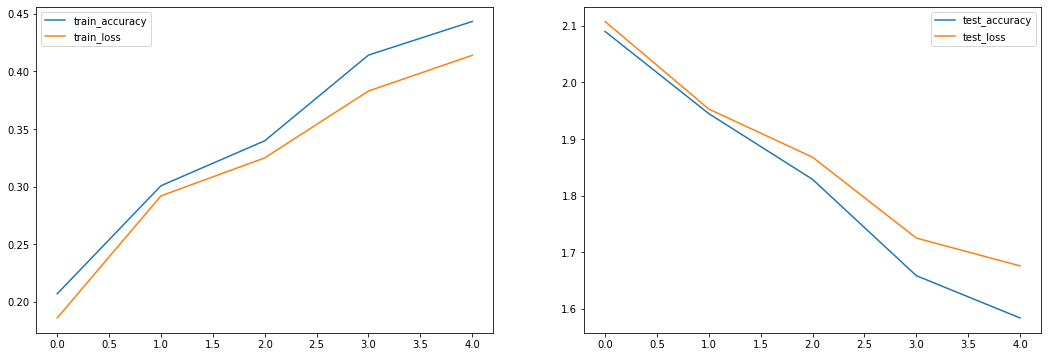

In [61]:
for m in conv_net.modules():
  if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
    torch.nn.init.xavier_normal_(m.weight)
    torch.nn.init.zeros_(m.bias)
optimizer = torch.optim.SGD(conv_net.parameters(), lr=best_configuration["learning_rate"], momentum=best_configuration["momentum_param"])
train_and_plot_results(trainloader, testloader, conv_net, conv_net.loss, optimizer, epochs, device)

###Weight Decay Regularization

accuracy:  0.097  loss:  2.3009587228298187


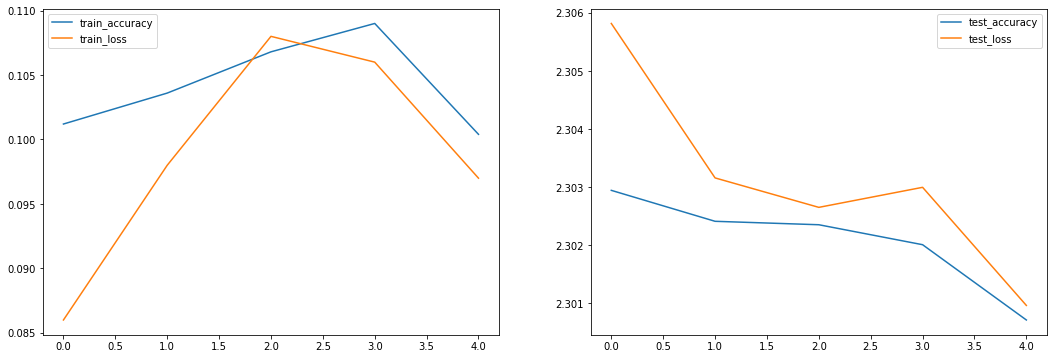

In [62]:
init_weights_normal(conv_net, best_configuration["init_std"])
# 1e-5 is best empirically out of (1e-3, 1e-4, 1e-5) although all are similar. 1e-2 takes too long to fit
optimizer = torch.optim.SGD(conv_net.parameters(), lr=best_configuration["learning_rate"], momentum=best_configuration["momentum_param"], weight_decay=1e-5)
train_and_plot_results(trainloader, testloader, conv_net, conv_net.loss, optimizer, epochs, device)

###Dropout

accuracy:  0.137  loss:  2.2726518362760544


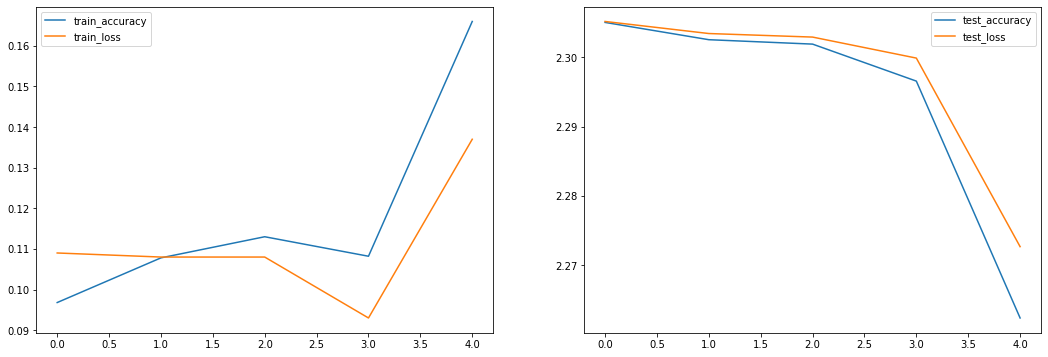

In [65]:
# the following result is from 30 epochs, 0.1 and 0.2 dropout on the first and second layer respectively
init_weights_normal(conv_net, best_configuration["init_std"])
optimizer = torch.optim.SGD(conv_net.parameters(), lr=best_configuration["learning_rate"], momentum=best_configuration["momentum_param"])
train_and_plot_results(trainloader, testloader, conv_net, conv_net.loss, optimizer, epochs, device)

accuracy:  0.284  loss:  2.0311273857951164


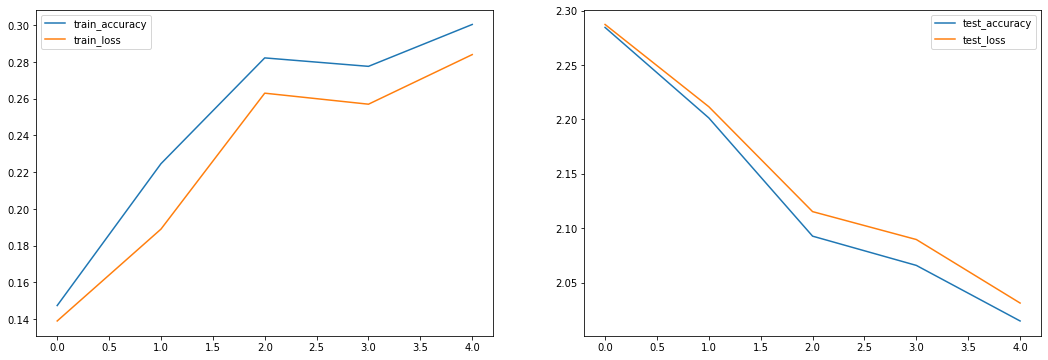

In [67]:
# 50 epochs and yet higher dropout - 0.15 and 0.3
# epochs = 50
init_weights_normal(conv_net, best_configuration["init_std"])
optimizer = torch.optim.SGD(conv_net.parameters(), lr=best_configuration["learning_rate"], momentum=best_configuration["momentum_param"])
train_and_plot_results(trainloader, testloader, conv_net, conv_net.loss, optimizer, epochs, device)

###Preprocessing

In [77]:
class ConvNetPCA(nn.Module):
    def __init__(self):
        super(ConvNetPCA, self).__init__()
        self.loss = nn.CrossEntropyLoss()
        self.classifier = nn.Sequential(
            nn.Conv2d(1, 64, 3), # for multi-channel PCA, set to 3 input channels
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2, ceil_mode=True),
            nn.Conv2d(64, 16, 3),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2, ceil_mode=True),
            nn.Flatten(),
            nn.Linear(144, 10)
        )
    
    def forward(self, x):
        return self.classifier(x)

conv_net_pca = ConvNetPCA().to(device)

In [74]:
MAX_INTENSITY = 255
train_x = trainset.data/MAX_INTENSITY
train_x = train_x[sample_train_idx,:].transpose((3, 0, 1, 2)).reshape(3, 5000, -1)
train_y = np.array(trainset.targets)[sample_train_idx]

test_x = testset.data/MAX_INTENSITY
test_x = test_x[sample_test_idx,:].transpose((3, 0, 1, 2)).reshape(3, 1000, -1)
test_y = np.array(testset.targets)[sample_test_idx]

pca = PCA(n_components=225, whiten=True) # see here why 225 components: https://towardsdatascience.com/integration-of-dimension-reduction-methods-and-neural-network-for-image-classification-96281963fe24
train_x_pca = np.ndarray((3, 5000, 15, 15))
test_x_pca = np.ndarray((3, 1000, 15, 15))
for i in range(3):
  train_x_pca[i] = pca.fit_transform(train_x[i]).reshape(train_x[i].shape[0], 15, 15)
  test_x_pca[i] = pca.fit_transform(test_x[i]).reshape(test_x[i].shape[0], 15, 15)
tensor_trainx = torch.Tensor(train_x_pca.transpose((1, 0, 2, 3)))
tensor_trainy = torch.tensor(train_y)
tensor_testx = torch.Tensor(test_x_pca.transpose((1, 0, 2, 3)))
tensor_testy = torch.tensor(test_y)

trainset_pca = torch.utils.data.TensorDataset(tensor_trainx,tensor_trainy)
testset_pca = torch.utils.data.TensorDataset(tensor_testx,tensor_testy)
trainloader_pca = torch.utils.data.DataLoader(trainset_pca, batch_size = batch_size,
                                          num_workers=2, shuffle = True)
testloader_pca = torch.utils.data.DataLoader(testset_pca, batch_size = batch_size,
                                          num_workers=2, shuffle = True)

accuracy:  0.126  loss:  3.7624652981758118


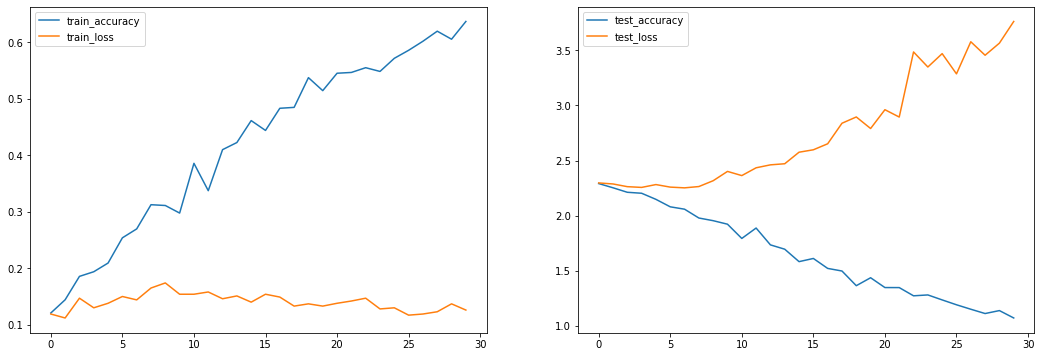

In [76]:
init_weights_normal(conv_net_pca, best_configuration["init_std"])
optimizer = torch.optim.SGD(conv_net_pca.parameters(), lr=best_configuration["learning_rate"], momentum=best_configuration["momentum_param"])
train_and_plot_results(trainloader_pca, testloader_pca, conv_net_pca, conv_net_pca.loss, optimizer, epochs, device)

In [78]:
# flat PCA attempt
MAX_INTENSITY = 255
train_x = trainset.data/MAX_INTENSITY
train_x = train_x[sample_train_idx,:].reshape(len(sample_train_idx), -1)
train_y = np.array(trainset.targets)[sample_train_idx]

test_x = testset.data/MAX_INTENSITY
test_x = test_x[sample_test_idx,:].reshape(len(sample_test_idx), -1)
test_y = np.array(testset.targets)[sample_test_idx]

pca = PCA(n_components=225, whiten=True)
train_x_pca = pca.fit_transform(train_x).reshape(train_x.shape[0], 15, 15)
test_x_pca = pca.fit_transform(test_x).reshape(test_x.shape[0], 15, 15)

tensor_trainx = torch.Tensor(train_x_pca).reshape(train_x.shape[0], 1, 15, 15)
tensor_trainy = torch.tensor(train_y)
tensor_testx = torch.Tensor(test_x_pca).reshape(test_x.shape[0], 1, 15, 15)
tensor_testy = torch.tensor(test_y)

trainset_pca = torch.utils.data.TensorDataset(tensor_trainx,tensor_trainy)
testset_pca = torch.utils.data.TensorDataset(tensor_testx,tensor_testy)
trainloader_pca = torch.utils.data.DataLoader(trainset_pca, batch_size = batch_size,
                                          num_workers=2, shuffle = True)
testloader_pca = torch.utils.data.DataLoader(testset_pca, batch_size = batch_size,
                                          num_workers=2, shuffle = True)

accuracy:  0.165  loss:  2.237282916903496


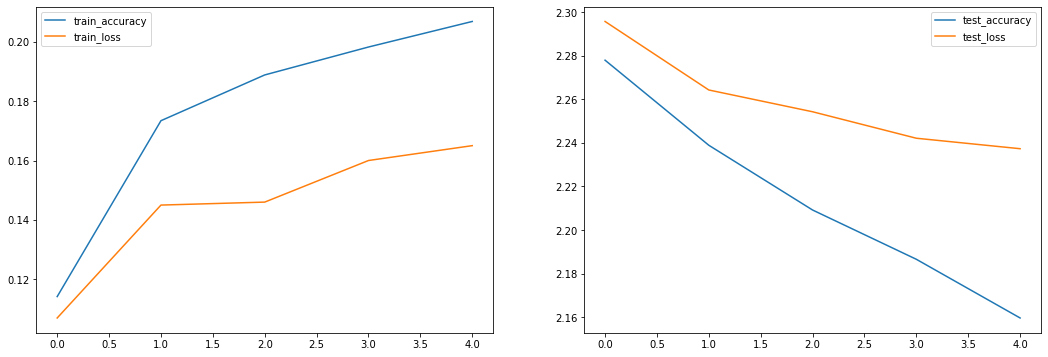

In [79]:
init_weights_normal(conv_net_pca, best_configuration["init_std"])
optimizer = torch.optim.SGD(conv_net_pca.parameters(), lr=best_configuration["learning_rate"], momentum=best_configuration["momentum_param"])
train_and_plot_results(trainloader_pca, testloader_pca, conv_net_pca, conv_net_pca.loss, optimizer, epochs, device)

###Network Width

In [80]:
class ConvNetWide(ConvNet):
    def __init__(self):
        super(ConvNetWide, self).__init__()
        self.classifier = nn.Sequential(
            nn.Conv2d(3, 256, 3),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(256, 64, 3),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2, ceil_mode=True),
            nn.Flatten(),
            nn.Linear(3136, 10)
        )
    
    def forward(self, x):
        return self.classifier(x)

class ConvNetWider(ConvNet):
    def __init__(self):
        super(ConvNetWider, self).__init__()
        self.classifier = nn.Sequential(
            nn.Conv2d(3, 512, 3),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(512, 256, 3),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2, ceil_mode=True),
            nn.Flatten(),
            nn.Linear(12544, 10)
        )
    
    def forward(self, x):
        return self.classifier(x)

conv_net_wide = ConvNetWide().to(device)
conv_net_wider = ConvNetWider().to(device)

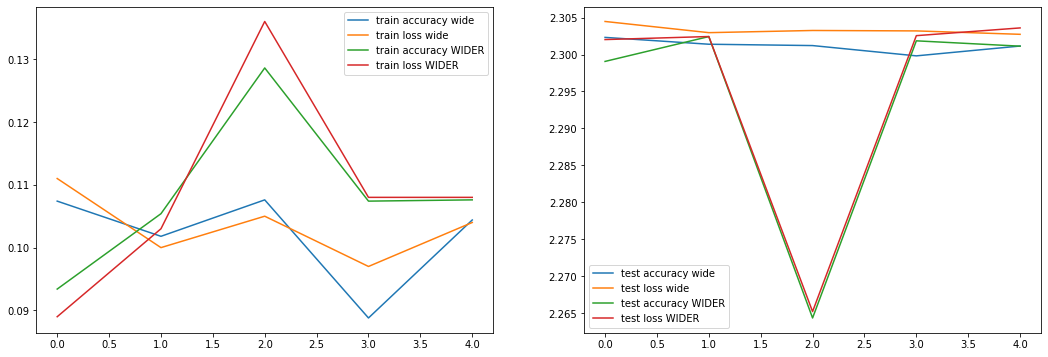

In [83]:
init_weights_normal(conv_net_wide, best_configuration["init_std"])
init_weights_normal(conv_net_wider, best_configuration["init_std"])
optimizer = torch.optim.SGD(conv_net_wide.parameters(), lr=best_configuration["learning_rate"], momentum=best_configuration["momentum_param"])
wide_results = train_and_return_results(trainloader, testloader, conv_net_wide, conv_net_wide.loss, optimizer, epochs, device)
optimizer = torch.optim.SGD(conv_net_wider.parameters(), lr=best_configuration["learning_rate"], momentum=best_configuration["momentum_param"])
wider_results = train_and_return_results(trainloader, testloader, conv_net_wider, conv_net_wider.loss, optimizer, epochs, device)

wide_labels = ['train accuracy wide', 'test accuracy wide', 'train loss wide', 'test loss wide']
wider_labels = ['train accuracy WIDER', 'test accuracy WIDER', 'train loss WIDER', 'test loss WIDER']

plot_results([(wide_results, wide_labels), (wider_results, wider_labels)])

###Network Depth

In [84]:
class ConvNetDeep(ConvNet):
    def __init__(self, depth, linear_size):
        super(ConvNetDeep, self).__init__()
        layers = [nn.Conv2d(3, 2**(depth + 4), 3),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2, ceil_mode=True)]
        current_channels = 2**(depth + 4)
        for i in range(depth - 1):
          layers += [nn.Conv2d(current_channels, 2**(depth + 3 - i), 3),
            nn.ReLU()]
          if i == int(depth / 2) - 1: # only add one additional max pooling layer because dimensions get ever smaller
            layers.append(nn.MaxPool2d(2, stride=2, ceil_mode=True))
          current_channels = 2**(depth + 3 - i)
        layers += [nn.MaxPool2d(2, stride=2, ceil_mode=True),
                   nn.Flatten(),
                   nn.Linear(linear_size, 10)]
        self.classifier = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.classifier(x)

conv_net_3 = ConvNetDeep(3, 288).to(device)
conv_net_4 = ConvNetDeep(4, 128).to(device)
conv_net_5 = ConvNetDeep(5, 32).to(device)

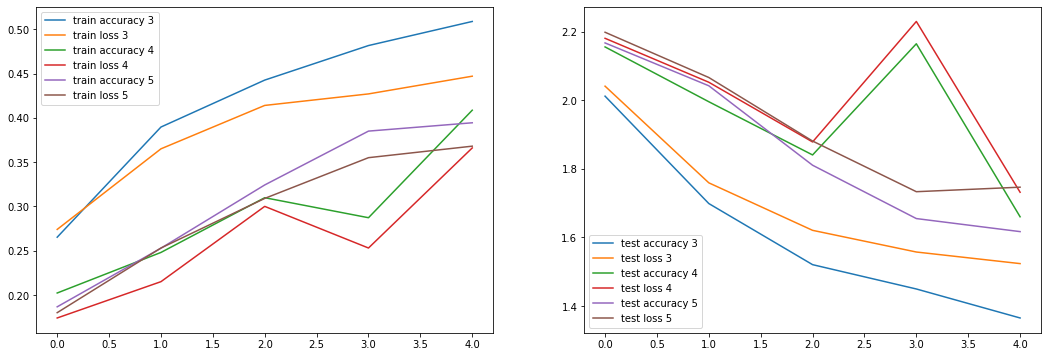

In [85]:
init_weights_normal(conv_net_3, best_configuration["init_std"])
init_weights_normal(conv_net_4, best_configuration["init_std"])
init_weights_normal(conv_net_5, best_configuration["init_std"])
optimizer = torch.optim.Adam(conv_net_3.parameters())
results_3 = train_and_return_results(trainloader, testloader, conv_net_3, conv_net_3.loss, optimizer, epochs, device)
optimizer = torch.optim.Adam(conv_net_4.parameters())
results_4 = train_and_return_results(trainloader, testloader, conv_net_4, conv_net_4.loss, optimizer, epochs, device)
optimizer = torch.optim.Adam(conv_net_5.parameters())
results_5 = train_and_return_results(trainloader, testloader, conv_net_5, conv_net_5.loss, optimizer, epochs, device)

labels = ['train accuracy', 'test accuracy', 'train loss', 'test loss']
labels_3 = [lbl + ' 3' for lbl in labels]
labels_4 = [lbl + ' 4' for lbl in labels]
labels_5 = [lbl + ' 5' for lbl in labels]

plot_results([(results_3, labels_3), (results_4, labels_4), (results_5, labels_5)])

###Residual Connections

In [86]:
# Adapted from: https://github.com/aladdinpersson/Machine-Learning-Collection/blob/master/ML/Pytorch/CNN_architectures/pytorch_resnet.py

class ResBlock(nn.Module):
  def __init__(self, in_channels, first_out_channels, iters = 1):
    super(ResBlock, self).__init__()
    layers = [nn.Conv2d(in_channels, first_out_channels, kernel_size=1)]
    current_channels = first_out_channels
    self.relu = nn.ReLU()
    for _i in range(iters):
      layers += [self.relu, nn.Conv2d(current_channels, 2*current_channels, kernel_size=1)]
      current_channels *= 2
    self.block = nn.Sequential(*layers)
    self.identity_pad = nn.Conv2d(in_channels, current_channels, kernel_size=1, bias=False) if in_channels != current_channels else None
    self.max_pool = nn.MaxPool2d(2, stride=2, ceil_mode=True)

  def forward(self, x):
    identity = x
    x = self.block(x)
    if self.identity_pad is not None:
      identity = self.identity_pad(identity)
    x += identity
    x = self.relu(x)
    x = self.max_pool(x)
    return x

class ResNet(nn.Module):
    def __init__(self, depth):
        super(ResNet, self).__init__()
        self.res_blocks = []
        curr_channels = 64
        self.loss = nn.CrossEntropyLoss()
        self.first_block = [
            nn.Conv2d(3, curr_channels, 3),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2, ceil_mode=True)
        ]
        if (depth % 2) == 0:
          self.res_blocks.append(ResBlock(64, 64, 2))
          depth -= 3
          curr_channels = 256
        for _i in range(int((depth - 1) / 2)):
          self.res_blocks.append(ResBlock(curr_channels, 128))
          curr_channels = 256
        self.classifier = nn.Sequential(
            *self.first_block,
            *self.res_blocks,
            nn.Flatten(),
            nn.Linear(int(16384 / (4**(len(self.res_blocks) - 1))), 10)
        )
    
    def forward(self, x):
        return self.classifier(x)

res_net_3 = ResNet(3).to(device)
res_net_4 = ResNet(4).to(device)
res_net_5 = ResNet(5).to(device)

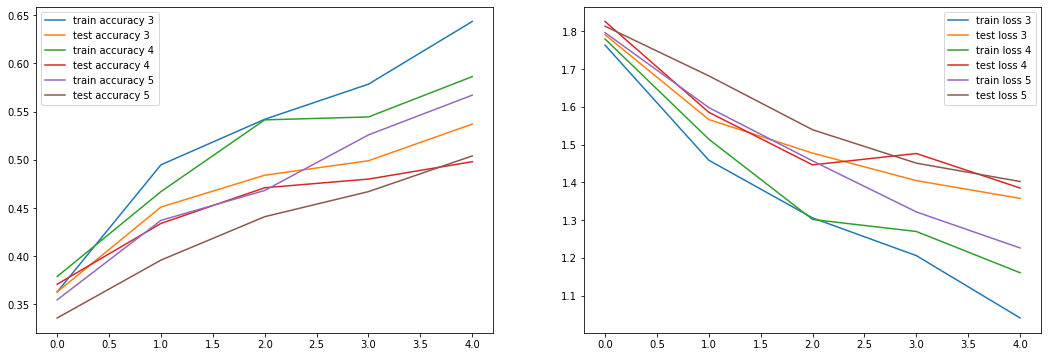

In [87]:
init_weights_normal(res_net_3, best_configuration["init_std"])
init_weights_normal(res_net_4, best_configuration["init_std"])
init_weights_normal(res_net_5, best_configuration["init_std"])
optimizer = torch.optim.Adam(res_net_3.parameters())
results_3 = train_and_return_results(trainloader, testloader, res_net_3, res_net_3.loss, optimizer, epochs, device)
optimizer = torch.optim.Adam(res_net_4.parameters())
results_4 = train_and_return_results(trainloader, testloader, res_net_4, res_net_4.loss, optimizer, epochs, device)
optimizer = torch.optim.Adam(res_net_5.parameters())
results_5 = train_and_return_results(trainloader, testloader, res_net_5, res_net_5.loss, optimizer, epochs, device)

labels = ['train accuracy', 'train loss', 'test accuracy', 'test loss']
labels_3 = [lbl + ' 3' for lbl in labels]
labels_4 = [lbl + ' 4' for lbl in labels]
labels_5 = [lbl + ' 5' for lbl in labels]

plot_results([(results_3, labels_3), (results_4, labels_4), (results_5, labels_5)])

### Part 4

#### Recurrent Neural Network - Basic Architecture

Diclosure - For this part, we used the skeleton of an official tutorial by Pytorch.

In [ ]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import torch
import random

def findFiles(path): return glob.glob(path)

# Previous to running this cell, user should load the data to local memory of the notebook
# from https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html
print(findFiles('data/names/*'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

['data/names/Portuguese.txt', 'data/names/Japanese.txt', 'data/names/Irish.txt', 'data/names/Spanish.txt', 'data/names/French.txt', 'data/names/Czech.txt', 'data/names/Dutch.txt', 'data/names/Scottish.txt', 'data/names/Chinese.txt', 'data/names/English.txt', 'data/names/Italian.txt', 'data/names/Greek.txt', 'data/names/Russian.txt', 'data/names/Arabic.txt', 'data/names/German.txt', 'data/names/Korean.txt', 'data/names/Vietnamese.txt', 'data/names/Polish.txt']
Slusarski


In [ ]:
#Split to train and test sets

trainset = {} 
testset = {}
SEED = 10

for category in all_categories:
  lines = category_lines[category]
  random.Random(SEED).shuffle(lines)
  seperator = int(len(lines)*0.2)
  testset[category] = lines[:seperator]
  trainset[category] = lines[seperator:]

In [ ]:
# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor


In [ ]:
# class RNN(nn.Module):
#     def __init__(self, input_size, hidden_size, output_size):
        
#         nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)

#         super(RNN, self).__init__()

#         self.hidden_size = hidden_size

#         self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
#         self.i2o = nn.Linear(input_size + hidden_size, output_size)
#         self.softmax = nn.LogSoftmax(dim=1)

#     def forward(self, input, hidden):
#         combined = torch.cat((input, hidden), 1)
#         hidden = self.i2h(combined)
#         output = self.i2o(combined)
#         output = self.softmax(output)
#         return output, hidden

#     def initHidden(self):
#         return torch.zeros(1, self.hidden_size)

class RNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(RNN, self).__init__()

        # Defining some parameters
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        #Defining the layers
        # RNN Layer
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)   
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_size)
    
    def forward(self, x):
        
        batch_size = x.size(0)

        # Initializing hidden state for first input using method defined below
        hidden = self.init_hidden(batch_size)

        # Passing in the input and hidden state into the model and obtaining outputs
        out, hidden = self.rnn(x, hidden)
        
        # Reshaping the outputs such that it can be fit into the fully connected layer
        out = out.contiguous().view(-1, self.hidden_dim)
        out = self.fc(out)
        
        return out, hidden
    
    def initHidden(self):
        return torch.zeros(1, self.hidden_dim)

In [ ]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(trainset[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor


In [ ]:
def train(model, category_tensor, line_tensor, criterion):
    hidden = model.initHidden()

    model.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = model(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in model.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

def calculate_test_loss(model, test_set, criterion):
  counter = 0
  loss = 0
  with torch.no_grad(): 
    for category in test_set:
      for line in test_set[category]:
        counter += 1
        hidden = model.initHidden()
        category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
        line_tensor = lineToTensor(line)
        for i in range(line_tensor.size()[0]):
          output, hidden = model(line_tensor[i], hidden)
        loss += criterion(output, category_tensor)
  return loss/counter

def calculate_parameter_l2_norm(model):
  total_norm = 0
  parameters = [p for p in model.parameters() if p.grad is not None and p.requires_grad]
  for p in parameters:
      param_norm = p.grad.detach().data.norm(2)
      total_norm += param_norm.item() ** 2
  return total_norm ** 0.5

In [ ]:
n_hidden = 100
rnn = RNN(n_letters, n_categories, n_hidden, 4)
hidden = torch.zeros(1, n_hidden)
learning_rate = 0.005 
criterion = nn.NLLLoss()

In [ ]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 2000

# Keep track of losses for plotting
current_loss = 0
train_losses = []
test_losses = []
param_l2_norm = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(rnn, category_tensor, line_tensor, criterion)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        train_losses.append(current_loss / iter)
        test_losses.append(calculate_test_loss(rnn, testset, criterion))
        param_l2_norm.append(calculate_parameter_l2_norm(rnn))
        

5000 5% (0m 14s) 1.7532 Hirano / Japanese ✓
10000 10% (0m 26s) 1.7613 Divoky / Czech ✓
15000 15% (0m 41s) 4.0344 Andringa / Spanish ✗ (Dutch)
20000 20% (0m 54s) 1.5323 Conchobhar / Irish ✓
25000 25% (1m 9s) 4.3301 Qureshi / Italian ✗ (Arabic)
30000 30% (1m 22s) 1.0272 Menendez / Spanish ✓
35000 35% (1m 36s) 2.7758 Pasternak / Czech ✗ (Polish)
40000 40% (1m 49s) 1.0865 Kassis / Arabic ✓
45000 45% (2m 3s) 2.1177 Petru / Italian ✗ (Czech)
50000 50% (2m 16s) 0.9542 Cao / Vietnamese ✓
55000 55% (2m 31s) 1.1479 Belrose / French ✓
60000 60% (2m 43s) 0.3241 Walentowicz / Polish ✓
65000 65% (2m 59s) 0.5795 Cardozo / Portuguese ✓
70000 70% (3m 11s) 1.5838 Luzzatto / Japanese ✗ (Italian)
75000 75% (3m 26s) 2.8038 Kwak / Czech ✗ (Korean)
80000 80% (3m 38s) 0.2512 Dang / Vietnamese ✓
85000 85% (3m 53s) 0.3704 Mcintyre / Scottish ✓
90000 90% (4m 6s) 0.9029 Narvaez / Spanish ✓
95000 95% (4m 21s) 0.0555 O'Brien / Irish ✓
100000 100% (4m 33s) 0.4122 Hao / Chinese ✓


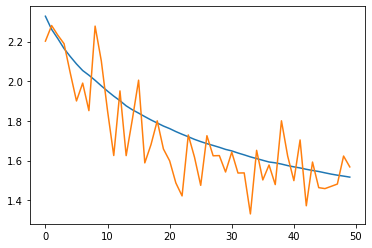

In [ ]:
from matplotlib import pyplot as plt

plt.plot(train_losses)
plt.plot(test_losses)

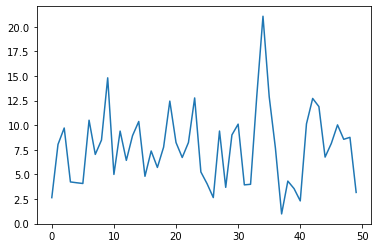

In [ ]:
plt.plot(param_l2_norm)